# Benchmark creation with [Polaris](https://github.com/polaris-hub/polaris)
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

The resulting benchmarks can be found in Polaris:
- [biogen/adme-fang-hclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-hclint-1)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm
import numpy as np

from sklearn.model_selection import ShuffleSplit

# polaris benchmark
from polaris.benchmark import (
    MultiTaskBenchmarkSpecification,
)

# polaris hub
from polaris.cli import PolarisHubClient
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization
org = "biogen"
data_name = "fang2023_ADME"
owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='biogen', external_id=None, type='organization')

In [3]:
BENCHMARK_DIR = f"gs://polaris-public/{org}/{data_name}/benchmarks"
DATASET_JSON = f"gs://polaris-public/{org}/{data_name}/datasets/adme-fang-1/dataset.json"
FIGURE_DIR =  f"gs://polaris-public/{org}/{data_name}/figures"

## Load existing Dataset
> **Attention:** \
> See more dataset creataion details in [02_polaris_adme-fang_dataset.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/02_polaris_adme-fang_dataset.ipynb).

In [4]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

In [5]:
dataset

{
  "name": "adme-fang-1",
  "description": "A DMPK datasets of six ADME in vitro endpoints from fang et al. 2023. ",
  "tags": [
    "adme"
  ],
  "user_attributes": {},
  "owner": "biogen",
  "polaris_version": "dev",
  "default_adapters": {},
  "zarr_root_path": null,
  "md5sum": "acb647cbd9a9505ce3ad49a2c8f35e0c",
  "readme": "![ADME](https://storage.googleapis.com/polaris-public/icons/icon_fang.png) \n\n## Background\n\nThe goal of accessing ADME properties is to understand how a potential drug candidate interacts with the human body, including absorption, distribution, metabolism, and excretion. This knowledge is crucial for evaluating efficacy, safety, and clinical potential, guiding drug development for optimal therapeutic outcomes. [Fang et al. 2023](https://doi.org/10.1021/acs.jcim.3c00160) has disclosed DMPK datasets collected over 20 months across six ADME in vitro endpoints, which are human and rat liver microsomal stability, MDR1-MDCK efflux ratio, solubility, and human and rat plasma protein binding. The dataset contains 885 to 3087 measures for the corresponding endpoints. The compounds show the chemical diversity across all ranges of the endpoints which are microsomal stability, plasma protein binding, permeability, and solubility.\n\n## Description of readout\n- Microsomal stability (human and rat):  `LOG HLM_CLint (mL/min/kg)`, `LOG RLM_CLint (mL/min/kg)`\n- Plasma protein binding (human and rat): `LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)`, `LOG PLASMA PROTEIN BINDING (RAT) (% unbound)`\n- Permeability: `LOG MDR1-MDCK ER (B-A/A-B)`\n- Solubility: `LOG SOLUBILITY PH 6.8 (ug/mL)`\n- **Number of molecules after curation**: 3516\n\n## Data resource\n**Reference**: [Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective]( https://doi.org/10.1021/acs.jcim.3c00160)\n\n**Github**: https://github.com/molecularinformatics/Computational-ADME\n\n**Raw data**: https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv \n\n## Data curation\nTo **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.\n\nThe full curation and creation process is documented in [01_polaris_adme-fang-1_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/01_polaris_adme-fang-1_data_curation.ipynb).\n",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Molecular hash ID. See <datamol.mol.hash_mol>",
      "user_attributes": {},
      "dtype": "object"
    },
    "MOL_smiles": {
      "is_pointer": false,
      "modality": "MOLECULE",
      "description": "Molecule SMILES string after cleaning and standardization.",
      "user_attributes": {},
      "dtype": "object"
    },
    "SMILES": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Original molecule SMILES string from the publication.",
      "user_attributes": {},
      "dtype": "object"
    },
    "LOG_HLM_CLint": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Human liver microsomal stability reported as intrinsic clearance",
      "user_attributes": {
        "unit": "mL/min/kg",
        "scale": "log",
        "organism": "human",
        "objective": "Higher value"
      },
      "dtype": "float64"
    },
    "LOG_RLM_CLint": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Rat liver microsomal stability reported as intrinsic clearance",
      "user_attributes": {
        "unit": "mL/min/kg",
        "scale": "log",
        "organism": "rat",
        "objective": "Lower value"
      },
      "dtype": "float64"
    },
    "LOG_MDR1-MDCK_ER": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "MDR1-MDCK efflux ratio (B-A/A-B

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test splits, and defining evaluation metrics to establish a baseline performance level.

In [10]:
table = dataset.table
mol_col = "MOL_smiles"

### Multitask learning benchmark for all the six ADME endpoints which share one train/test split. 

In [11]:
# regression
TEST_SIZE = 0.2
SEED = 111

# random split
random_splitter = ShuffleSplit(n_splits=5, test_size=TEST_SIZE, random_state=SEED)
random_split = next(random_splitter.split(X=table[mol_col].values))
split_key = "random"

### Check distribution of train/test set in the chemical space

  0%|          | 0/3521 [00:00<?, ?it/s]

'https://storage.googleapis.com/polaris-public/biogen/fang2023_ADME/figures/multitask_random_chemspace.png'

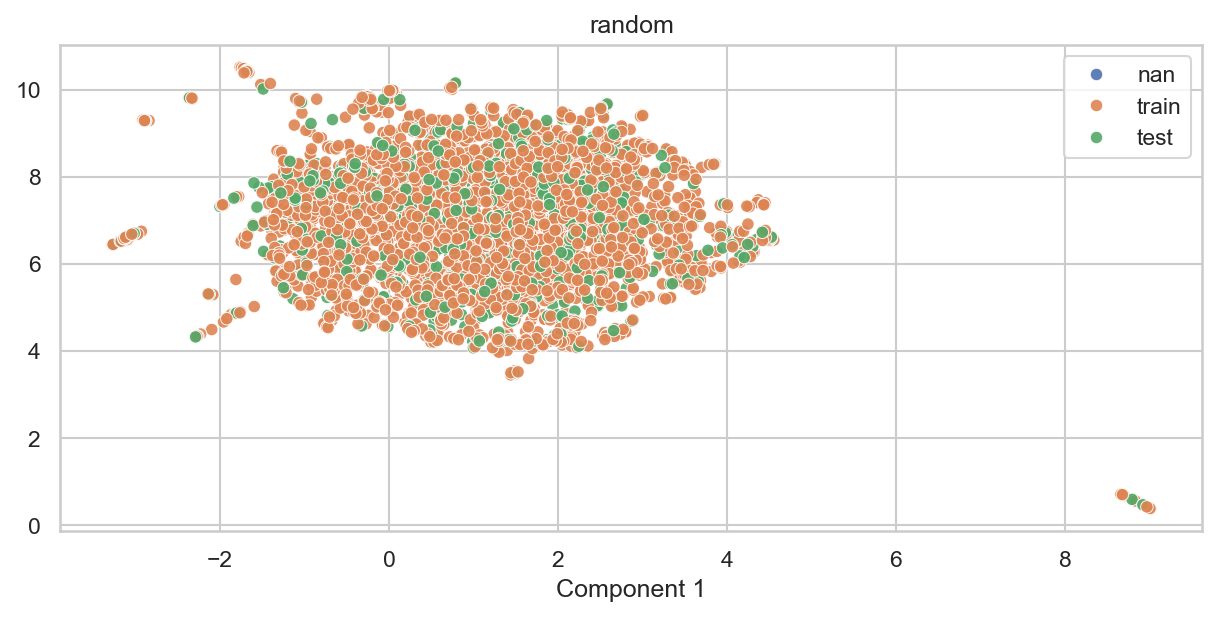

In [12]:
from utils.docs_utils import visualize_split_chemspace
from utils.auroris_utils import save_image

fig = visualize_split_chemspace(table[mol_col], {split_key: random_split})
save_image(fig, dm.fs.join(FIGURE_DIR, f"multitask_{split_key}_chemspace.png"))

In [16]:
benchmark_version = "v1"
benchmark_name = f"adme-fang-r-{benchmark_version}"
readme_name = f"fang2023_ADME_public_multitask_reg_v{benchmark_version}"

data_cols = [
    "LOG_HLM_CLint",
    "LOG_RLM_CLint",
    "LOG_MDR1-MDCK_ER",
    "LOG_HPPB",
    "LOG_RPPB",
    "LOG_SOLUBILITY",
]

In [17]:
benchmark_multi = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    target_type="regression", 
    input_cols=mol_col,
    split=random_split,
    tags=["adme", "multitask"],
    owner=owner,
    description="A multitask benchmark for six ADME endpoints, utilizing a shared random split. ",
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    readme=load_readme(
        f"gs://polaris-public/readme/benchmarks/{readme_name}_readme.md"
    ),
)
SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi.to_json(SAVE_DIR)
print(path)

# upload to polaris hub
# benchmark_multi.upload_to_hub(owner="biogen")

gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-r-1/benchmark.json
